# Encoder Decoder

## Set up

In [54]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

PyTorch version: 2.1.0+cu121


In [55]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [56]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20

loaded numpy bitmaps, 8 classes
[144722, 194843, 120527, 121661, 142167, 134680, 143570, 156883]


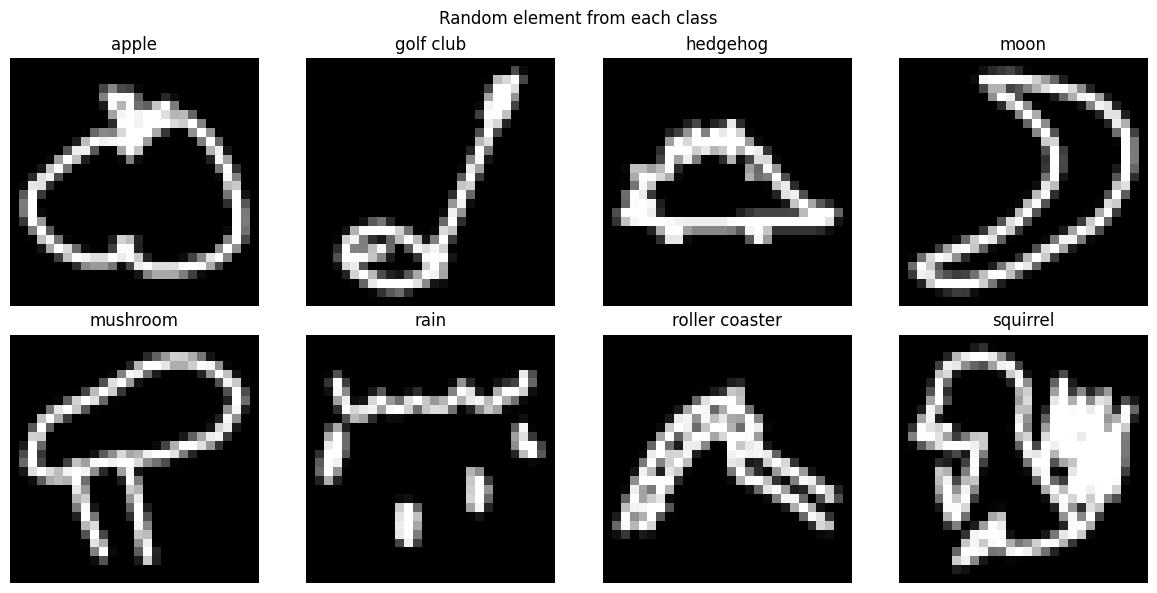

In [57]:
resources_folder = 'resources'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

classes_sizes = []

for i in range(nb_classes):
    classes_sizes.append(len(data[i]))

images = []
labels = []

# Reshape and parse data to image and labels
for i in range(nb_classes):
    for j in range(classes_sizes[i]):
        images.append(data[i][j].reshape(HEIGHT, WIDTH))
        labels.append(classes[i])

print(classes_sizes)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
# Show image for each class
for i in range(nb_classes):
    # Sum of previous classes_size
    start_index = sum(classes_sizes[:i])
    end_index = start_index + classes_sizes[i]

    # Random element from each class
    random_index = random.randint(start_index, end_index)

    axes[i // num_cols, i % num_cols].imshow(images[random_index], cmap='gray')
    axes[i // num_cols, i % num_cols].set_title(labels[random_index])
    axes[i // num_cols, i % num_cols].axis('off')
    

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

In [58]:
# Show len of train and test data
print(f'Train data: {len(images)}')
print(f'Test data: {len(labels)}')

Train data: 1159053
Test data: 1159053


In [59]:
class Autoencoder(nn.Module):
    def __init__(self, layer_sizes=[WIDTH * HEIGHT, 128, 64, 32]):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Add encoder layers
        for i in range(len(layer_sizes) - 1):
            self.encoder.add_module(f"encoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                self.encoder.add_module(f"encoder_relu_{i}", nn.ReLU())
                self.encoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))

        # Add decoder layers
        for i in range(len(layer_sizes) - 1, 0, -1):
            self.decoder.add_module(f"decoder_{i}", nn.Linear(layer_sizes[i], layer_sizes[i-1]))
            if i > 1:
                self.decoder.add_module(f"decoder_relu_{i}", nn.ReLU())
                self.encoder.add_module(f"encoder_dropout_{i}", nn.Dropout(0.3))

        self.decoder.add_module("decoder_sigmoid", nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def print_model(self):
        print(self.encoder)
        print(self.decoder)

## Try with simple model

In [60]:
autoencoder_model = Autoencoder([WIDTH * HEIGHT, 256]).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [61]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / 256}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=256, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=256, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 3.0625


In [62]:
# Too much images, take sub part (10000)
sub_dataset_size = 2000

# print percentage used
print(f'Percentage of data used: {sub_dataset_size / len(images) * 100}%')

# Suffle data and split images and labels into train and test sets
shuffler = np.random.permutation(len(images))
print(shuffler)
split_percentage = 0.8

train_images = []
train_labels = []

test_images = []
test_labels = []

for i in range(sub_dataset_size):
    if i < sub_dataset_size * split_percentage:
        train_images.append(images[shuffler[i]])
        train_labels.append(labels[shuffler[i]])
    else:
        test_images.append(images[shuffler[i]])
        test_labels.append(labels[shuffler[i]])


# Normalize data and convert to PyTorch tensors
train_normalized_images = np.array(train_images).astype(np.float32) / 255.0
train_torch_images = torch.from_numpy(train_normalized_images).to(device)

test_normalized_images = np.array(test_images).astype(np.float32) / 255.0
test_torch_images = torch.from_numpy(test_normalized_images).to(device)

print(train_labels[:20])
 

Percentage of data used: 0.1725546631603559%
[774547 180954 174610 ... 710719 868310 559494]
['rain', 'golf club', 'golf club', 'hedgehog', 'roller coaster', 'mushroom', 'squirrel', 'apple', 'rain', 'apple', 'moon', 'squirrel', 'mushroom', 'moon', 'moon', 'rain', 'golf club', 'hedgehog', 'apple', 'rain']


In [63]:
def train_autoencoder(autoencoder_model, train_set, test_set, criterion, optimizer, num_epochs, batch_size):
    train_psnr_values = []
    train_ssim_values = []

    test_psnr_values = []
    test_ssim_values = []

    for epoch in range(num_epochs):
        # Train by batch of images
        for i in range(0, len(train_set), batch_size):
            batch = train_set[i:i+batch_size]

            # Forward pass
            encoded, decoded = autoencoder_model(batch.view(-1, WIDTH * HEIGHT))
            loss = criterion(decoded, batch.view(-1, WIDTH * HEIGHT))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate PSNR and SSIM for train and test sets
        train_psnr = 0
        train_ssim = 0
        test_psnr = 0
        test_ssim = 0

        for image in train_set:
            encoded, decoded = autoencoder_model(image.view(-1, WIDTH * HEIGHT))
            decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

            image_matrix = image.cpu().detach().numpy()
            decoded_matrix = decoded.cpu().detach().numpy()[0]

            train_psnr += psnr(image_matrix, decoded_matrix)
            train_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        for image in test_set:
            encoded, decoded = autoencoder_model(image.view(-1, WIDTH * HEIGHT))
            decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

            image_matrix = image.cpu().detach().numpy()
            decoded_matrix = decoded.cpu().detach().numpy()[0]

            test_psnr += psnr(image_matrix, decoded_matrix)
            test_ssim += ssim(image_matrix, decoded_matrix, data_range=decoded_matrix.max() - decoded_matrix.min())

        train_psnr /= len(train_set)
        train_ssim /= len(train_set)
        test_psnr /= len(test_set)
        test_ssim /= len(test_set)

        train_psnr_values.append(train_psnr)
        train_ssim_values.append(train_ssim)
        test_psnr_values.append(test_psnr)
        test_ssim_values.append(test_ssim)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train PSNR: {train_psnr:.4f}, Train SSIM: {train_ssim:.4f}, Test PSNR: {test_psnr:.4f}, Test SSIM: {test_ssim:.4f}')

    return loss, train_psnr_values, train_ssim_values, test_psnr_values, test_ssim_values

# Call the function
num_epochs = 50
batch_size = 8
loss, train_psnr_values, train_ssim_values, test_psnr_values, test_ssim_values \
    = train_autoencoder(autoencoder_model, train_torch_images, test_torch_images, criterion, optimizer, num_epochs, batch_size)
    

Epoch [1/50], Loss: 0.0620, Train PSNR: 12.3183, Train SSIM: 0.3070, Test PSNR: 12.1314, Test SSIM: 0.2918
Epoch [2/50], Loss: 0.0416, Train PSNR: 13.9765, Train SSIM: 0.4517, Test PSNR: 13.4909, Test SSIM: 0.4242
Epoch [3/50], Loss: 0.0305, Train PSNR: 15.3788, Train SSIM: 0.5424, Test PSNR: 14.5976, Test SSIM: 0.5083
Epoch [4/50], Loss: 0.0243, Train PSNR: 16.7022, Train SSIM: 0.6086, Test PSNR: 15.6640, Test SSIM: 0.5717
Epoch [5/50], Loss: 0.0205, Train PSNR: 17.7831, Train SSIM: 0.6544, Test PSNR: 16.5110, Test SSIM: 0.6174
Epoch [6/50], Loss: 0.0178, Train PSNR: 18.7233, Train SSIM: 0.6900, Test PSNR: 17.2274, Test SSIM: 0.6535
Epoch [7/50], Loss: 0.0156, Train PSNR: 19.5421, Train SSIM: 0.7187, Test PSNR: 17.8177, Test SSIM: 0.6827
Epoch [8/50], Loss: 0.0137, Train PSNR: 20.2591, Train SSIM: 0.7415, Test PSNR: 18.3145, Test SSIM: 0.7062
Epoch [9/50], Loss: 0.0121, Train PSNR: 20.8886, Train SSIM: 0.7594, Test PSNR: 18.7402, Test SSIM: 0.7252
Epoch [10/50], Loss: 0.0107, Train PS

In [64]:
# Define a function to plot Train and Test PSNR and SSIM values
def plot_psnr_ssim(train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(train_psnr_values, label='Train PSNR')
    axes[0].plot(test_psnr_values, label='Test PSNR')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('PSNR')
    axes[0].legend()

    axes[1].plot(train_ssim_values, label='Train SSIM')
    axes[1].plot(test_ssim_values, label='Test SSIM')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('SSIM')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


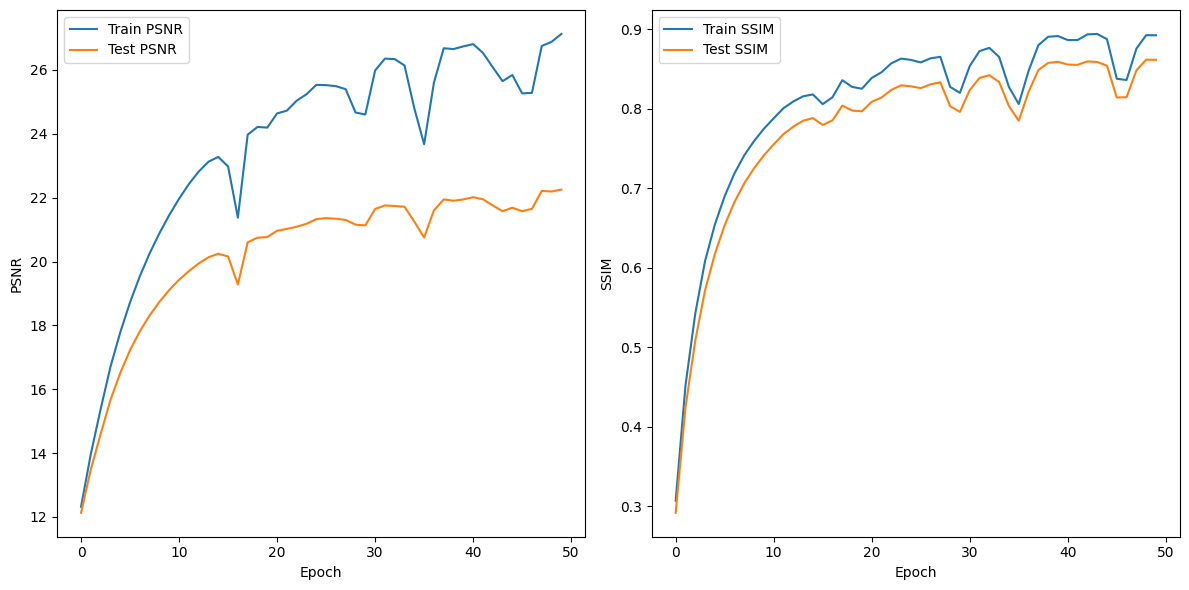

In [65]:
# Call the function
plot_psnr_ssim(train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values)

In [66]:
# Define a function to show original and reconstructed images
def show_images(train_images, train_labels, autoencoder_model):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    for i in range(num_cols):
        # Train images
        axes[0, i].imshow(train_images[i], cmap='gray')
        axes[0, i].set_title(train_labels[i])
        axes[0, i].axis('off')

        # Reconstructed images
        encoded, decoded = autoencoder_model(train_torch_images[i].view(-1, WIDTH * HEIGHT))
        decoded = decoded.view(-1, HEIGHT, WIDTH)  # Reshape decoded images

        axes[1, i].imshow(decoded.cpu().detach().numpy()[0], cmap='gray')
        axes[1, i].set_title(train_labels[i])
        axes[1, i].axis('off')

    plt.show()

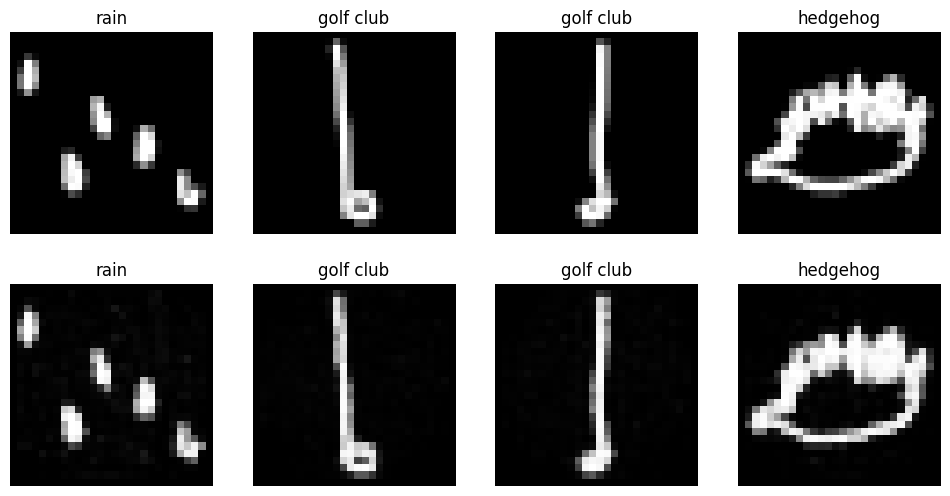

In [67]:
# Call the function
show_images(train_images, train_labels, autoencoder_model)

## Try with a different model

In [81]:
layers = [WIDTH * HEIGHT, WIDTH * HEIGHT, 256]
autocoder_2 = Autoencoder(layers).to(device)

# Define loss function and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autocoder_2.parameters(), lr=0.001)

# Print architecture
autocoder_2.print_model()

# Compression factor
print(f'Compression factor: {WIDTH * HEIGHT / layers[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=784, bias=True)
  (encoder_relu_0): ReLU()
  (encoder_dropout_0): Dropout(p=0.2, inplace=False)
  (encoder_1): Linear(in_features=784, out_features=256, bias=True)
  (encoder_dropout_2): Dropout(p=0.2, inplace=False)
)
Sequential(
  (decoder_2): Linear(in_features=256, out_features=784, bias=True)
  (decoder_relu_2): ReLU()
  (decoder_1): Linear(in_features=784, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 3.0625


In [82]:
# Call the function
num_epochs = 50
batch_size = 32

loss, train_psnr_values, train_ssim_values, test_psnr_values, test_ssim_values \
    = train_autoencoder(autocoder_2, train_torch_images, test_torch_images, criterion, optimizer, num_epochs, batch_size)

Epoch [1/50], Loss: 0.0954, Train PSNR: 11.0789, Train SSIM: 0.0998, Test PSNR: 11.0404, Test SSIM: 0.0947
Epoch [2/50], Loss: 0.0756, Train PSNR: 11.8570, Train SSIM: 0.1850, Test PSNR: 11.6860, Test SSIM: 0.1710
Epoch [3/50], Loss: 0.0672, Train PSNR: 12.3669, Train SSIM: 0.2570, Test PSNR: 12.1329, Test SSIM: 0.2343
Epoch [4/50], Loss: 0.0591, Train PSNR: 12.8587, Train SSIM: 0.3273, Test PSNR: 12.5105, Test SSIM: 0.2966
Epoch [5/50], Loss: 0.0536, Train PSNR: 13.3523, Train SSIM: 0.4002, Test PSNR: 12.8790, Test SSIM: 0.3588
Epoch [6/50], Loss: 0.0479, Train PSNR: 13.7799, Train SSIM: 0.4457, Test PSNR: 13.1817, Test SSIM: 0.3974
Epoch [7/50], Loss: 0.0456, Train PSNR: 14.1858, Train SSIM: 0.4936, Test PSNR: 13.4120, Test SSIM: 0.4337
Epoch [8/50], Loss: 0.0421, Train PSNR: 14.4495, Train SSIM: 0.5154, Test PSNR: 13.4935, Test SSIM: 0.4473
Epoch [9/50], Loss: 0.0392, Train PSNR: 14.7230, Train SSIM: 0.5440, Test PSNR: 13.6446, Test SSIM: 0.4690
Epoch [10/50], Loss: 0.0361, Train PS

KeyboardInterrupt: 

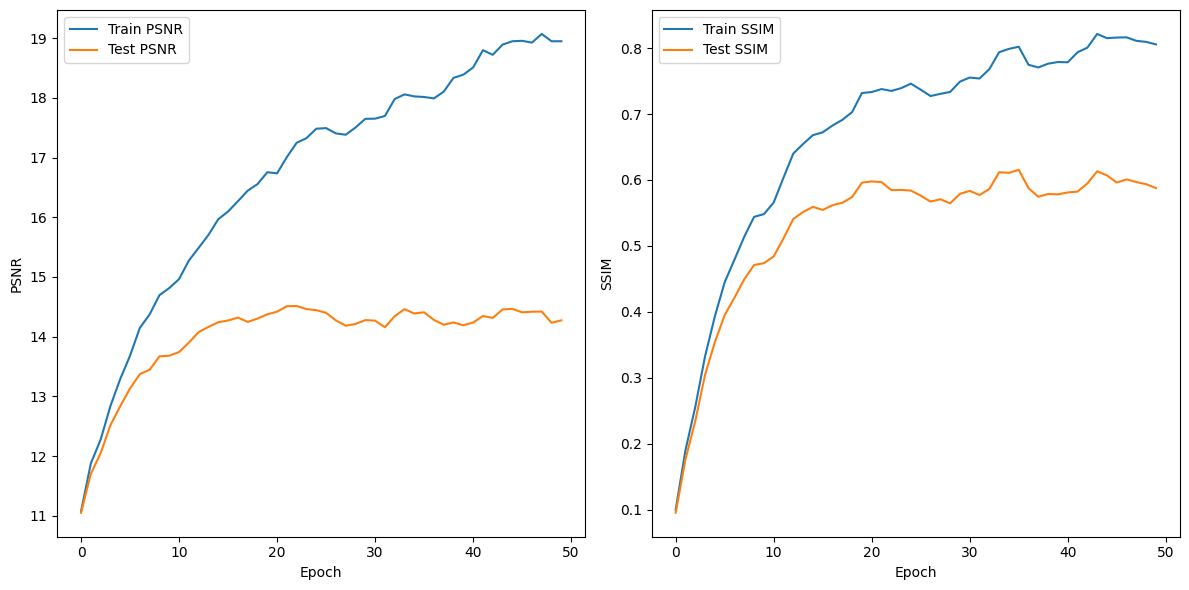

In [ ]:
plot_psnr_ssim(train_psnr_values, test_psnr_values, train_ssim_values, test_ssim_values)

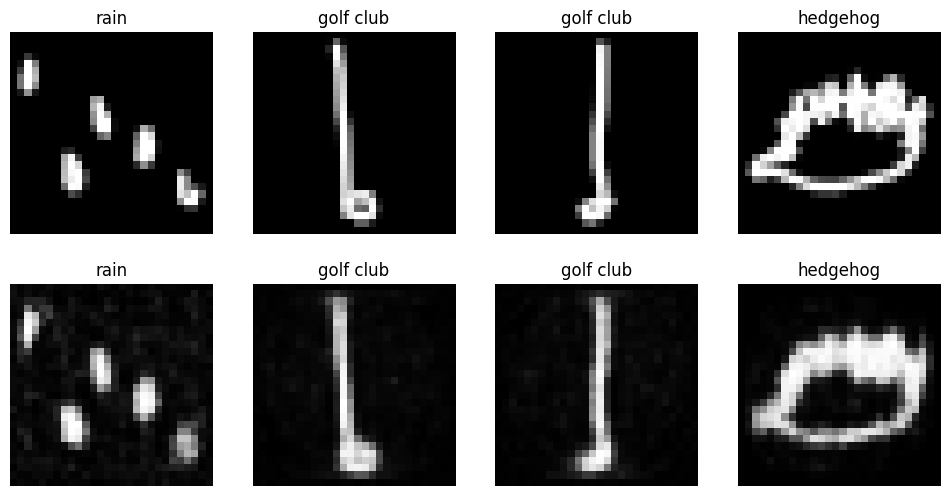

In [ ]:
show_images(train_images, train_labels, autocoder_2)

## Try with resnet18 architecture

In [73]:
# Use pretrained model

# Load pretrained model

pretrained_model = models.resnet18(pretrained=True)
pretrained_model = pretrained_model.to(device)

# Print pretrained model architecture
print(pretrained_model)

# Freeze all layers

for param in pretrained_model.parameters():
    param.requires_grad = False

# Add custom layers

pretrained_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, nb_classes)
)

# Print new model architecture
print(pretrained_model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/maxence/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maxence/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
# Define a function to train the model
def train_pretained_model():
    

SyntaxError: incomplete input (1788380066.py, line 3)